# Machine Learning Engineering nano Degree - Capstone Project

## Flowers recognition

<a id="top"></a>

This aim of this notebook is to define and train a Deep Convolutional Network able to recognize flower species based on a picture. 

The dataset is the ["Flowers Recognition"](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset from Kaggle donated by [Alexander Mamaev](https://www.kaggle.com/alxmamaev).

The dataset contains 4362 pictures devided in 5 classes:

- Daisy
- Dandelion
- Rose
- Sunflower
- Tulip 

---

Notebook plan:

* [Step 1](#step1) : Imports and print packages version
* [Step 2](#step1) : Load the dataset

<a id="step1"></a>
## 1. imports
[to the top](#top)

In [5]:
import tensorflow as tf
tf.__version__

'1.5.0'

In [15]:
import sys
import os
# set TensorFlow as Keras backend
os.environ['KERAS_BACKEND'] = 'tensorflow'

#import glob
import urllib

from custom_utils import print_list, plot_images

import matplotlib as mlp
%matplotlib inline  

import matplotlib.pyplot as plt
#plt.style.use('ggplot')

import seaborn as sns

import numpy as np

from sklearn import __version__ as sklearn_version
from sklearn.datasets import load_files 

from keras import __version__ as keras_version
from keras.utils import np_utils

from tensorflow import __version__ as tf_version

import cv2

In [16]:
# print packages version

print("Packages versions:")
print("------------------")
print("Python: {}".format(sys.version))
print("Matplotlib : {}".format(mlp.__version__))
print("Seaborn : {}".format(sns.__version__))
print("Numpy : {}".format(np.__version__))
print("Scikit-learn : {}".format(sklearn_version))
print("Keras : {}".format(keras_version))
print("Keras backend: {}".format(os.environ['KERAS_BACKEND']))
print("Tensor Flow : {}".format(tf_version))
print("openCV : {}".format(cv2.__version__))

Packages versions:
------------------
Python: 3.5.3 |Continuum Analytics, Inc.| (default, Feb 22 2017, 21:28:42) [MSC v.1900 64 bit (AMD64)]
Matplotlib : 2.2.2
Seaborn : 0.8.1
Numpy : 1.13.3
Scikit-learn : 0.19.0
Keras : 2.0.2
Keras backend: tensorflow
Tensor Flow : 1.8.0
openCV : 3.1.0


<a id="step2"></a>
## 2. load the dataset
[to the top](#top)

In [8]:
path = "./flowers/"

print("Collecting files from data folder : {}".format(path))
data = load_files(path, load_content=False)

flowers_files = data["filenames"]
flowers_targets = np_utils.to_categorical(data["target"],5)
flowers_target_names = data["target_names"]

print("{} flower pictures found".format(flowers_files.shape[0]))
print_list(flowers_target_names, 'types of flower found')


4326 flower pictures found
5 types of flower found:
	o daisy
	o dandelion
	o rose
	o sunflower
	o tulip


<a id="step3"></a>
##  3. Visualize some pictures
[to the top](#top)

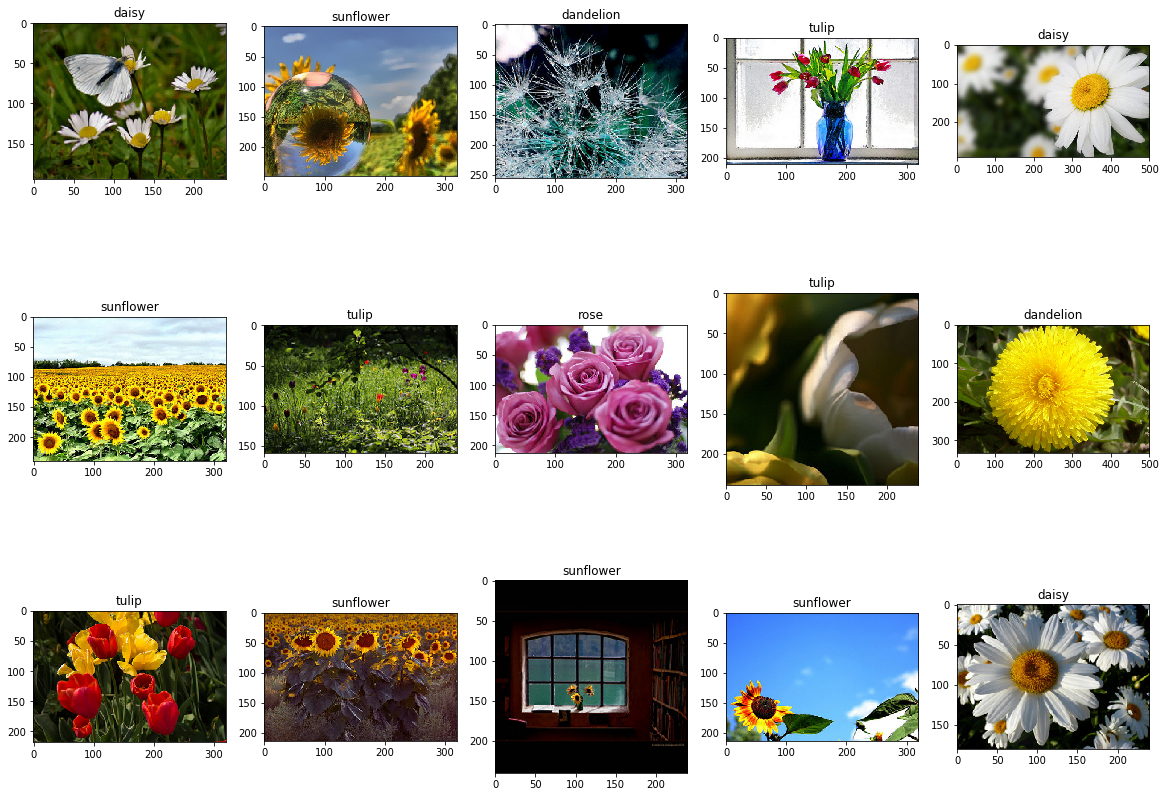

In [4]:
n_samples = 15
sample_idx = np.random.choice(list(range(flowers_files.shape[0])), n_samples)
sample_files = flowers_files[sample_idx]
sample_titles = [flowers_target_names[i] for i in data["target"][sample_idx]]

plot_images(sample_files, sample_titles)

** Note: ** the flower pictures are of various sizes, angle of view, light conditions. We can also observe that some pictures have been artistically post-processed, adding colour filters altering the original colour of the flower. 
In some case the flower is not the main subject of the picture, as such we often have on the picture non-flower subjects such as insects, babies, wine bottle, etc. 

The Dandelion flower appear in 2 states: the yellow-orange flower and the whithe spherical seeds head "blowball" form.

<a id="step4"></a>
## 4. Classes distribution
[to the top](#top)

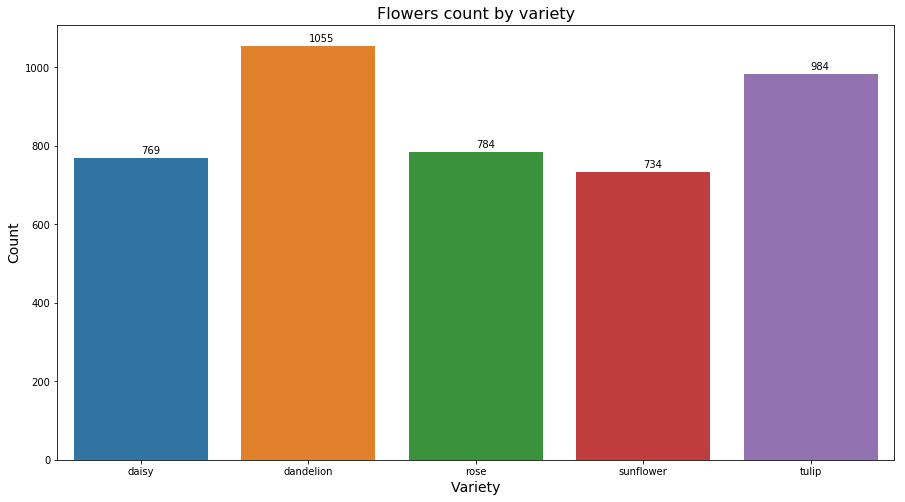

In [40]:
_, counts = np.unique(data['target'], return_counts=True)

plt.figure(figsize=(15,8))
p = sns.barplot(x=flowers_target_names, y=counts)
plt.title("Flowers count by variety", fontsize=16)
plt.xlabel("Variety", fontsize=14)
plt.ylabel("Count", fontsize=14)

for i, count in enumerate(counts):
    p.text(i, count+10, count)  
    
plt.show()

** Note : ** classes distribution is slightly unbalanced. 

In [14]:
b

array([ 769, 1055,  784,  734,  984], dtype=int64)

[keras applications reference page](https://keras.io/applications/)

In [ ]:
#from keras.applications.xception import Xception
#model = Xception(weights='imagenet')

array([[ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])